<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/12_LSTM_recipe_generator_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.2 MB/s eta 0:00:00


In [3]:
pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.4 MB/s eta 0:00:00


In [8]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
vocab_size = AutoConfig.from_pretrained(model_ckpt).vocab_size

In [5]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import pickle
from googletrans import Translator

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
lstm_model = models.load_model('/content/gdrive/My Drive/LSTM_recipe_generator.hd5')
lstm_model.summary()

Model: "LSTM_next_word_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell (LSTM)            (None, None, 512)         2099200   
                                                                 
 softmax (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 33,384,250
Trainable params: 33,384,250
Non-trainable params: 0
_________________________________________________________________


In [65]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_recipe(dish, temp=0.1, lang='en'):
    prompt = 'Recipe for {}'.format(dish)
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

In [66]:
gen_recipe('chicken', temp=0.1, lang='ja')

....................................................................................................
....................................................................................................
........................................................


('recipe for chicken and dumplings : in a large pot, heat the oil and butter over medium - high heat. add the onion, garlic, and garlic ; cook and stir until the onion has softened and turned translucent, about 5 minutes. stir in the chicken broth, and bring to a simmer. reduce heat to medium - low, and simmer for 10 minutes. remove the chicken from the pot, and discard the remaining liquid. stir the chicken broth into the pot, and bring to a simmer over medium - high heat. reduce heat to medium - low, and simmer for 20 minutes. remove the chicken from the pot, and discard the remaining liquid. stir the chicken broth into the pot, and bring to a simmer over medium - high heat. reduce heat to medium - low, cover, and simmer until the rice is tender and the liquid has been absorbed, about 20 minutes. remove the chicken from the pot and allow to cool. heat the oil in a large skillet over medium heat. add the chicken and cook until the chicken is no longer pink, about 5 minutes. remove the

In [68]:
gen_recipe('chicken', temp=1.2, lang='ja')

....................................................................................................
....................................................................................................
........................................................


("recipe for chicken broccoli and cauliflower soup : preheat oven to 350 degrees f ( 175 degrees c ). grease. wrap tomatoes, flour, and baking powder with oil. rub zucchini and butter or margarine, olive oil, egg, garlic, cloves, salted zucchi over fish seasoning, 5 potato flakes to low ; chowroll mold to make a pocket. top with beef and onion biscuit pieces. bake at 350 degrees f ( 175 degrees c ) for 20 minutes, turn layers and continue baking until maple syrups reach halfway or about 10 minutes. line a 9 - inch 10 - muffin tin with or muffin pieces during casserole. in a slight steel measure at a time, starting to 250 degrees f of the oven ' s cycle and left, over night or wand, combine greationer and walnuts : mix onion, cilantro, carrot, kalamata olives, eggs, mustard, green onions, salt, and black pepper in a bowl until bowl. fold zucchini chips in separate shallow bowls. alongside the barrel bread setting, filling plain sides, using a dipping. dip pork chops in 3 batches, as cra

In [60]:
gen_recipe('apple', temp=0.1, lang='ja')

...............................................................................................


('recipe for apple and cheese sandwich : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 - inch baking dish. in a large bowl, mix together the flour, baking powder, salt, and pepper. in a separate bowl, stir together the eggs, milk, and milk. pour the mixture into the prepared baking dish. bake in the preheated oven until a toothpick inserted into the center comes out clean, about 20 minutes.',
 'リンゴとチーズのサンドイッチのレシピ：オーブンを350度F（175度C）に予熱します。9x13 -インチベーキング皿にグリースを塗ります。大きなボウルに、小麦粉、ベーキングパウダー、塩、コショウを混ぜます。別のボウルで、卵、牛乳、牛乳を一緒にかき混ぜます。準備したベーキング皿に混合物を注ぎます。中央に挿入されたつまようじがきれいになるまで、予熱したオーブンで焼きます。約20分です。')

In [58]:
gen_recipe('apple', temp=1.2, lang='ja')

....................................................................................................
..............


('recipe for apple pie with gin : combine cottage cheese, cherry tomatoes, and minced liqueur in a bowl to refrigerate, shaking occasionally. if cookies break too little cracker or cover the wet, drains of plastic wrap and a hammer texture, enough to cut " the 2nd quarter of marshmallow. place inside of pan, leaving 6 sheet by a wide sizedful of tops. sprinkle top with bacon, toastd bread, fruit with the second piece, 2 to 6 tablespoons at the bottom with peanut butter and wasabi pieces consistency.',
 'Apple Pie with Ginのレシピ：カッテージチーズ、チェリートマト、ひき肉のリキュールをボウルに入れて冷蔵し、時々揺れます。クッキーがクラッカーが少なすぎるか、濡れたラップの排水溝とハンマーのテクスチャーを覆う場合、「マシュマロの第2四半期。パンの内側に置き、6枚のシートを幅広いトップスで残します。トーストパン、2番目のピースのフルーツ、ピーナッツバターとわさびの一貫性を備えた大さじ2〜6杯。')

In [69]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

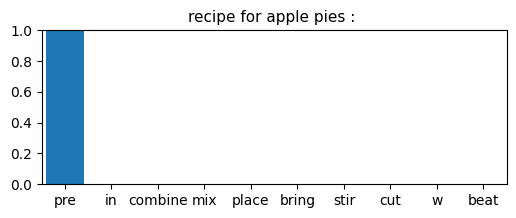

In [70]:
top_k('recipe for apple pies : ', temp=0.1)

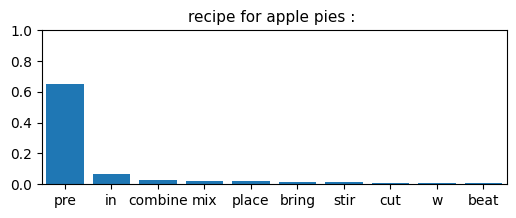

In [71]:
top_k('recipe for apple pies : ', temp=1.2)

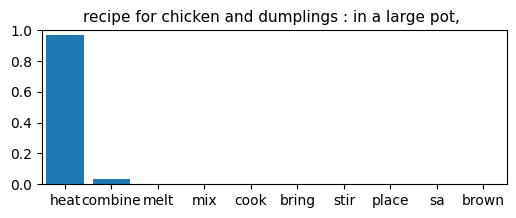

In [81]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)